# Importing libraries, EDA

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

In [2]:
# Read csv
originaldata = pd.read_csv('https://raw.githubusercontent.com/Bomsk/DA3_2023/main/Assignment%202/listings.csv')

# Drop rows with missing prices
data = originaldata.dropna(subset=['price'])

# Clean price column
data["price"] = data["price"].replace('[\$,]', '', regex=True).astype(float)

# Filter
data = data[(data['accommodates'] >= 2) &            # 'accommodates' for 2-6 people
            (data['accommodates'] <= 6) &            # 'accommodates' for 2-6 people   
            (data['room_type'] != 'Hotel room') &    # filter out 'Hotel room'
            (data['room_type'] != 'Shared room')]    # filter out 'Shared room'

data

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20231227173752,2023-12-28,city scrape,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,NaN,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.54,4.79,M130003350,f,1,1,0,0,1.16
2,905944,https://www.airbnb.com/rooms/905944,20231227173752,2023-12-28,city scrape,Rental unit in Shibuya · ★4.78 · 2 bedrooms · ...,NaN,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.91,4.78,4.78,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.52
5,1196177,https://www.airbnb.com/rooms/1196177,20231227173752,2023-12-28,city scrape,Home in 足立区 · ★4.75 · 1 bedroom · 1.5 shared b...,NaN,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,...,4.90,4.70,4.78,M130007760,f,1,0,1,0,0.85
6,3845889,https://www.airbnb.com/rooms/3845889,20231227173752,2023-12-27,city scrape,Rental unit in Suginami-ku · ★4.86 · 1 bedroom...,NaN,Koenji town is very unique and stimulating pla...,https://a0.muscache.com/pictures/e498a703-e523...,19089769,...,4.96,4.90,4.87,M130000777,f,2,2,0,0,0.97
7,3846001,https://www.airbnb.com/rooms/3846001,20231227173752,2023-12-27,city scrape,Rental unit in Suginami-ku · ★4.92 · Studio · ...,NaN,NaN,https://a0.muscache.com/pictures/d697e82d-cb99...,19089769,...,4.95,4.90,4.85,M130008732,f,2,2,0,0,1.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13717,1052523990478131414,https://www.airbnb.com/rooms/1052523990478131414,20231227173752,2023-12-28,city scrape,Rental unit in Katsushika City · ★New · 2 bedr...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,552216877,...,NaN,NaN,NaN,M130035708,t,2,2,0,0,NaN
13718,1052570322244321995,https://www.airbnb.com/rooms/1052570322244321995,20231227173752,2023-12-28,city scrape,Home in Shinagawa City · ★New · 1 bedroom · 1 ...,NaN,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,28621978,...,NaN,NaN,NaN,M130025425,f,7,0,7,0,NaN
13719,1052573121521757761,https://www.airbnb.com/rooms/1052573121521757761,20231227173752,2023-12-28,city scrape,Home in Shinagawa City · ★New · 1 bedroom · 1 ...,NaN,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,28621978,...,NaN,NaN,NaN,M130025425,f,7,0,7,0,NaN
13721,1052618956131641134,https://www.airbnb.com/rooms/1052618956131641134,20231227173752,2023-12-28,city scrape,Rental unit in Taito City · ★New · 2 bedrooms ...,NaN,Ichiyu Tokyo Apartment is near Iriya and Asaku...,https://a0.muscache.com/pictures/miso/Hosting-...,292115979,...,NaN,NaN,NaN,M130019957,f,47,45,2,0,NaN


In [3]:
# basic variables inc neighbourhood
basic_vars = [
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed"
]

# reviews
reviews = [
    "number_of_reviews",
    "review_scores_rating"
]

# dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type",
    "room_type:property_type"
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed",
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed"
]

In [4]:
# there are 3 sets

predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

In [5]:
# Check for columns with NA values and drop them
for i in predictors_2:
    if data[i].isna().sum() > 0:
        data = data.dropna(subset=[i])

In [6]:
data_train, data_holdout = train_test_split( data, train_size=0.7, random_state=42)

In [7]:
data_train.shape, data_holdout.shape

((6043, 75), (2591, 75))

# Models

## Model 1 - Random Forest

In [8]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [9]:
rfr = RandomForestRegressor(random_state = 20240129)

tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [10]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-49317.167 total time=   0.1s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-26593.958 total time=   0.1s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-15589.089 total time=   0.1s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-20679.158 total time=   0.1s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-30516.736 total time=   0.1s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-49554.782 total time=   0.1s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-26961.204 total time=   0.1s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-16063.116 total time=   0.1s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-20901.901 total time=   0.1s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-30764.121 total time=   0.1s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-49651.796 total 

In [11]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-28539.221804
1,6,10,-28849.025012
2,6,15,-28982.858241
3,8,5,-28229.655036
4,8,10,-28519.896628
5,8,15,-28680.900222
6,10,5,-28025.256754
7,10,10,-28266.598916
8,10,15,-28416.621829
9,12,5,-27950.217771


In [12]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,28539.22,28849.03,28982.86
8,28229.66,28519.90,28680.90
10,28025.26,28266.60,28416.62
12,27950.22,28146.37,28258.34


In [13]:
print(rf_model.best_score_, '\n')
print(rf_model.best_params_, '\n')
print(rf_model.best_estimator_, '\n')

-27950.21777099149 

{'max_features': 12, 'min_samples_leaf': 5} 

RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240129) 



### Diagnostics

In [14]:
# grid search object
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 2.50052787e-03, 0.00000000e+00, 2.92050816e-05,
       0.00000000e+00, 1.90425842e-02, 1.29977249e-03, 0.00000000e+00,
       2.39410830e-02, 1.42955616e-02, 0.00000000e+00, 0.00000000e+00,
       1.12996085e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.25848693e-05, 5.06987987e-05,
       1.38249802e-02, 3.79395452e-04, 6.01510693e-05, 0.00000000e+00,
       0.00000000e+00, 7.14725172e-03, 0.00000000e+00, 4.36723382e-05,
       5.91726480e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.89477887e-02, 2.30915342e-03, 3.98896750e-03, 0.00000000e+00,
       1.57333304e-02, 0.00000000e+00, 2.94817620e-02, 6.29883284e-03,
       4.53757168e-03, 4.40366054e-02, 4.45511034e-04, 0.00000000e+00,
       1.49398029e-03, 6.34662795e-04, 0.00000000e+00, 0.00000000e+00,
       1.82884411e-02, 1.17847358e-04, 0.00000000e+00, 0.00000000e+00,
       3.97437851e-07, 3.65791390e-05, 0.00000000e+00, 4.27918678e-07,
      

In [15]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Entire condo],0.002501
property_type[T.Entire cottage],0.000000
property_type[T.Entire guest suite],0.000029
property_type[T.Entire guesthouse],0.000000
...,...
neighbourhood_cleansed[T.Toshima Ku],0.004648
accommodates,0.171179
beds,0.112435
number_of_reviews,0.098741


In [16]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,17.1%,17.1%
1,property_type[T.Entire villa],11.3%,28.4%
2,beds,11.2%,39.7%
3,review_scores_rating,10.6%,50.2%
4,number_of_reviews,9.9%,60.1%
5,neighbourhood_cleansed[T.Shinjuku Ku],4.5%,64.6%
6,bathrooms_text[T.1.5 baths],4.4%,69.0%
7,neighbourhood_cleansed[T.Sumida Ku],3.4%,72.4%
8,bathrooms_text[T.1 bath],2.9%,75.3%
9,property_type[T.Room in aparthotel],2.9%,78.2%


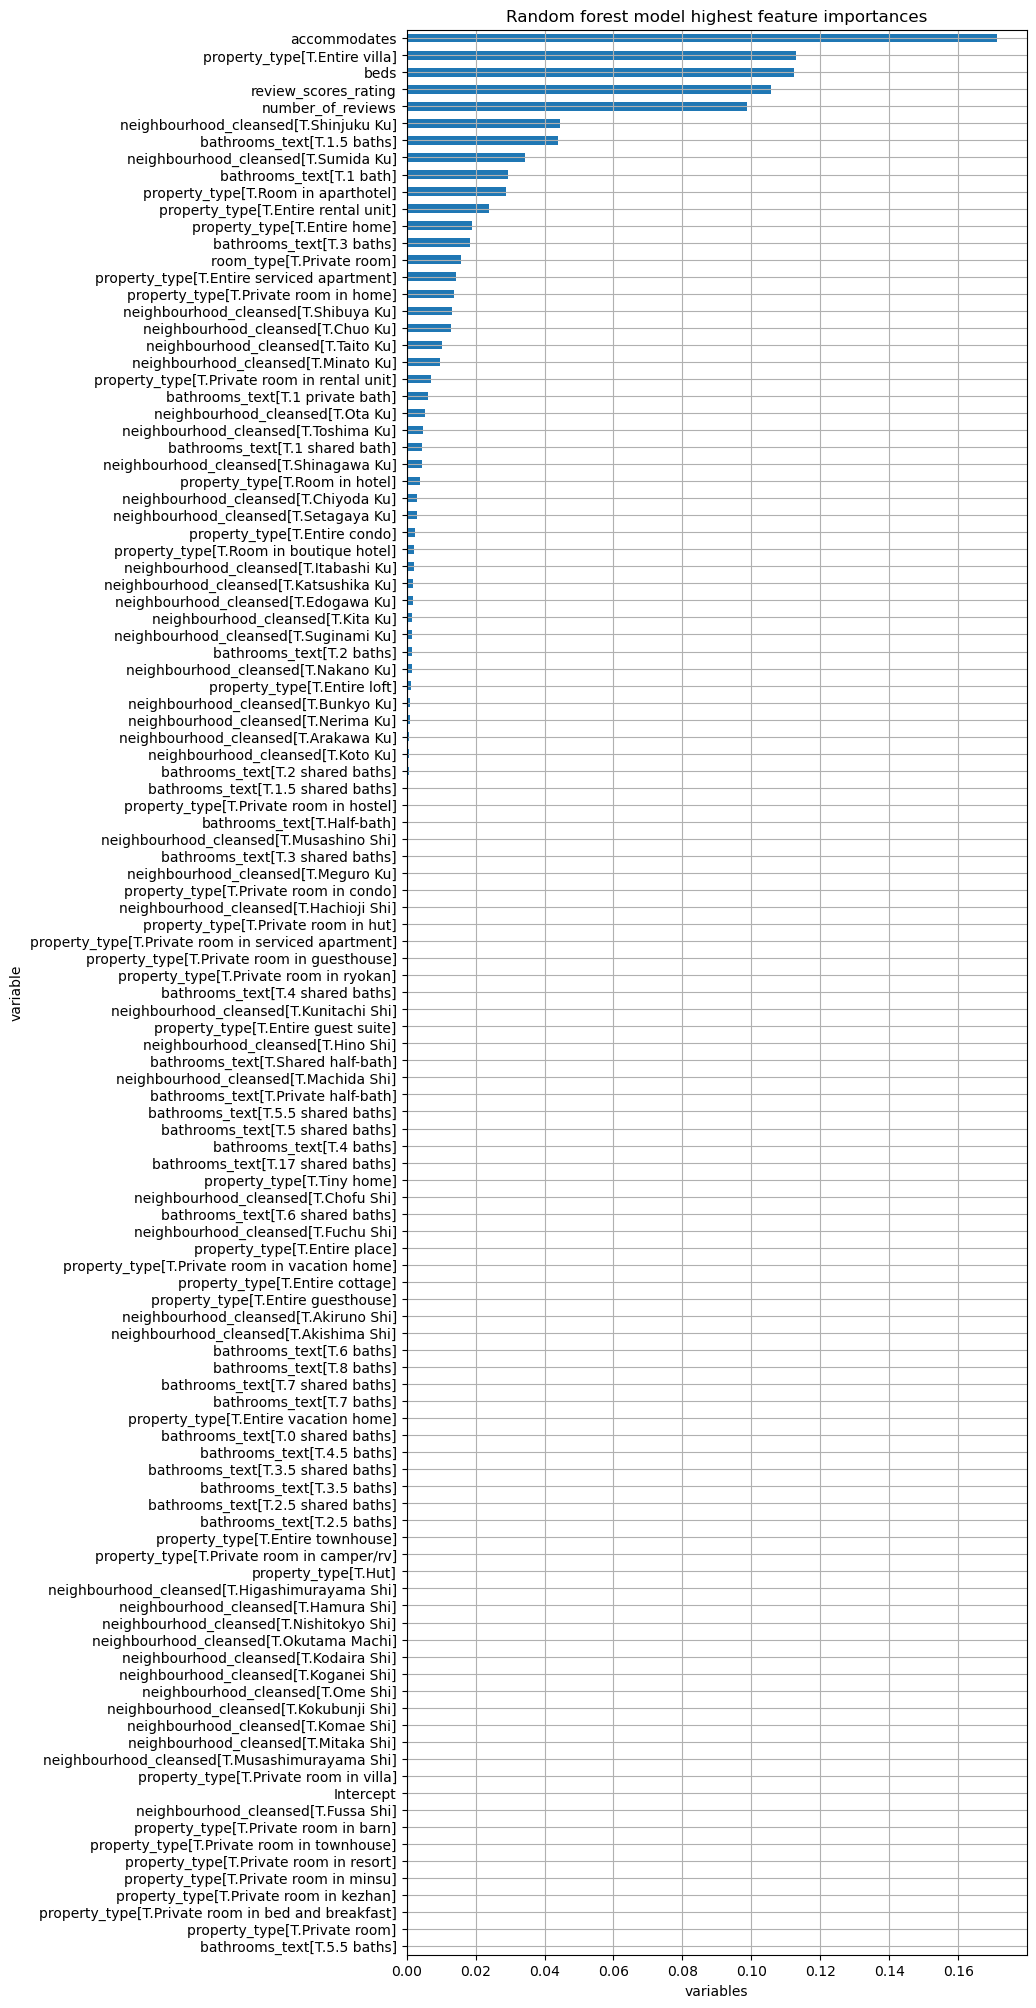

In [17]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (8,25), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

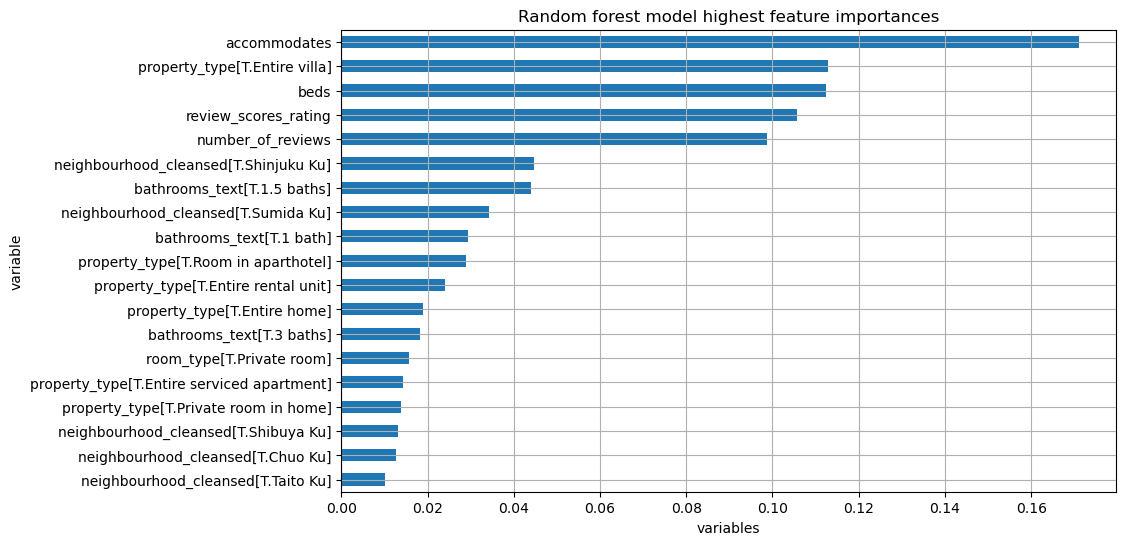

In [18]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

# tider table

df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [19]:
# defining 2 sets of columns

categorical_columns = [
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed"
]

numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

# PIPELINE!!

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),  # the transformation
    ("num", "passthrough", numerical_columns)])         # the columns for the transformation

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [20]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

CPU times: user 578 ms, sys: 7.43 ms, total: 586 ms
Wall time: 272 ms


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'room_type',
                                                   'bathrooms_text',
                                                   'neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['accommodates', 'beds',
                                                   'number_of_reviews',
                                                   'review_scores_rating'])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=20240129))])

In [21]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: user 1.3 s, sys: 22.8 ms, total: 1.33 s
Wall time: 1.33 s


In [22]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
accommodates,0.164353
beds,0.058088
property_type,0.064607
room_type,0.026541
bathrooms_text,0.010200
neighbourhood_cleansed,0.135434
number_of_reviews,0.022813
review_scores_rating,0.027175


In [23]:
grouped = [
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed"
]

df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,16.4%,16.4%
1,neighbourhood_cleansed,13.5%,30.0%
2,property_type,6.5%,36.4%
3,beds,5.8%,42.2%
4,room_type,2.7%,44.9%
5,bathrooms_text,1.0%,45.9%


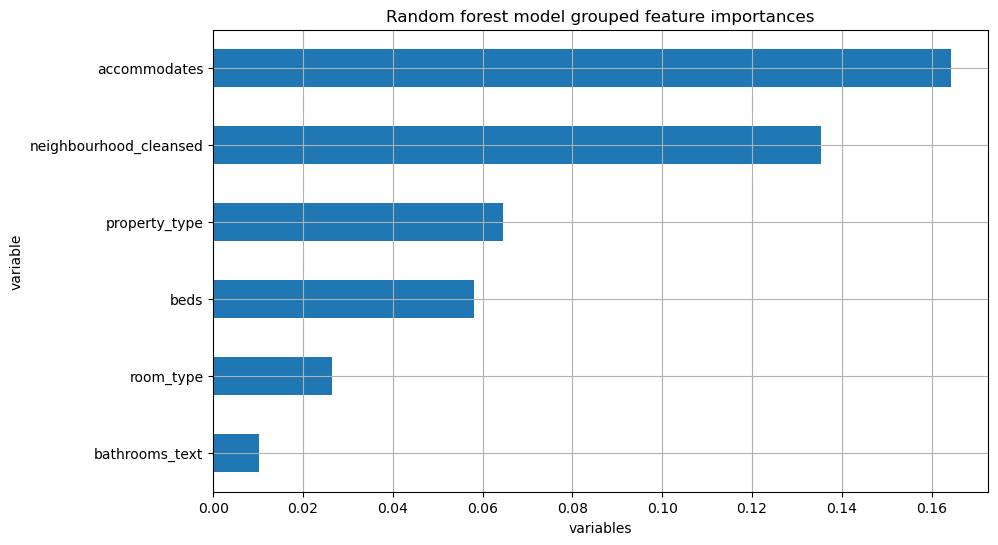

In [24]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [25]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,accommodates,0.164353,0.171179
1,neighbourhood_cleansed,0.135434,0.284175
2,property_type,0.064607,0.396610
3,beds,0.058088,0.502197
4,review_scores_rating,0.027175,0.600939
5,room_type,0.026541,0.645521
6,number_of_reviews,0.022813,0.689557
7,bathrooms_text,0.010200,0.723851


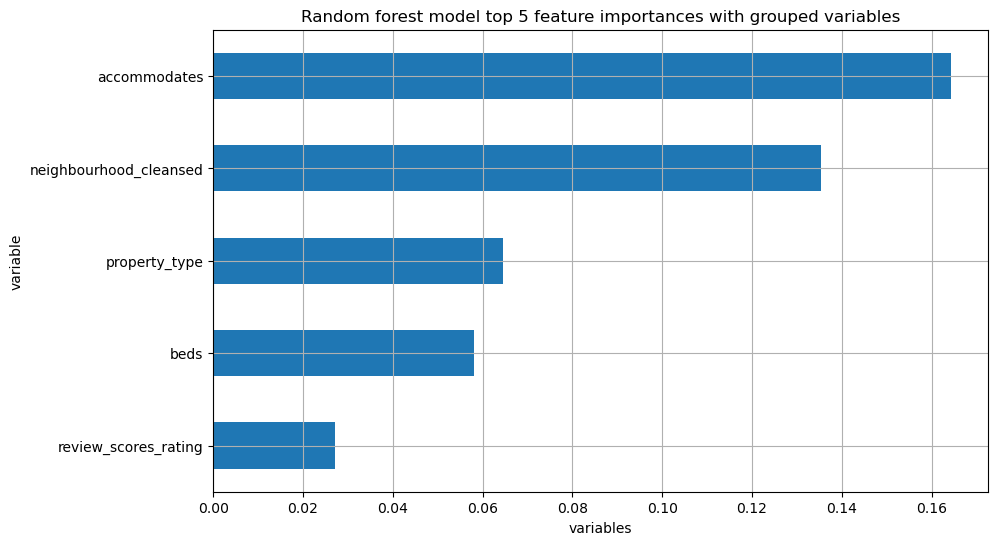

In [26]:
df_clean_varimp.iloc[0:5]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 5 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

### Partial dependence 

In [27]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["accommodates"], kind="average"
)

pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

,number of accomodates,average price
0,2,20830.886330
1,3,25143.405049
2,4,27954.156611
3,5,30758.995901
4,6,32452.336138


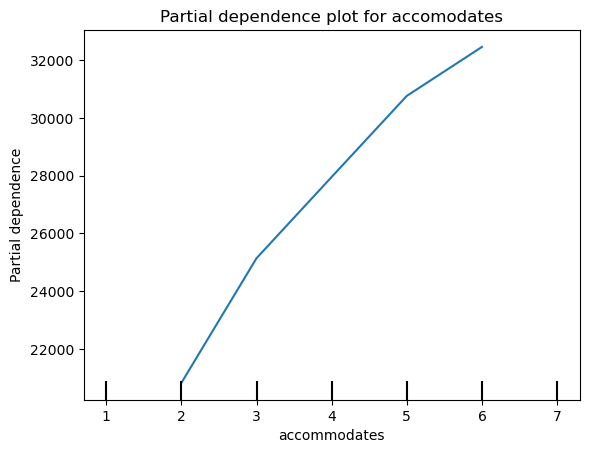

In [28]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 7, num=7)}
)
display.plot()
plt.title('Partial dependence plot for accomodates')
plt.show();

### Subsample performance: RMSE / mean(y) 

***Creating tables of heterogeneity by various grouping factors***
- Apartment size

In [29]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_pipeline.predict(data_holdout[predictors_2])
)

data_holdout_w_prediction['is_low_size'] = data_holdout_w_prediction.accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

data_holdout_w_prediction.iloc[0:5, -5:]

,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,predicted_price,is_low_size
6806,0,0,3.01,25516.806272,large apt
4577,10,0,0.70,18933.338119,small apt
6307,0,0,1.64,45988.754300,large apt
5739,0,0,0.35,20824.733042,large apt
6040,0,0,1.90,17395.858619,small apt


In [30]:
data_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    19679.810494
small apt    11223.209668
dtype: float64

In [31]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

accom_subset

,rmse,mean_price,rmse_norm
is_low_size,,,
large apt,22099.95,33247.02,0.66
small apt,12427.19,19245.13,0.65


- Fancy neighborhoods

In [32]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.neighbourhood_cleansed.isin(
        [
            "Shibuya Ku",
            "Shinjuku Ku",
            "Shinagawa Ku",
            "Minato Ku",
            "Chiyoda Ku",
            "Chuo Ku",
        ]
    )
].groupby("neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

neightbourhood_subset

,rmse,mean_price,rmse_norm
neighbourhood_cleansed,,,
Chiyoda Ku,17497.52,34059.46,0.51
Chuo Ku,19223.09,32690.79,0.59
Minato Ku,15052.01,30954.08,0.49
Shibuya Ku,12788.47,30080.37,0.43
Shinagawa Ku,49216.15,32839.72,1.50
Shinjuku Ku,17204.81,30312.09,0.57


- Property type

In [33]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.property_type.isin(["Entire home", "Entire loft", "Private room in home", "Entire cottage", "Entire guesthouse"])
].groupby("property_type")
proptype_subset = calculate_rmse(grouped_object)

proptype_subset

,rmse,mean_price,rmse_norm
property_type,,,
Entire home,18198.07,31572.28,0.58
Entire loft,10377.12,16362.00,0.63
Private room in home,7632.10,11815.07,0.65


In [34]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout

,rmse,mean_price,rmse_norm
Total,17169.86,25130.14,0.68


In [35]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough", "------"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("------")

type_rows

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
Type,------,------,------
Borough,------,------,------
------,------,------,------


### Subsample performance

In [36]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        type_rows.iloc[[3]],
        all_holdout,
    ]
)

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
large apt,22099.95,33247.02,0.66
small apt,12427.19,19245.13,0.65
Type,------,------,------
Entire home,18198.07,31572.28,0.58
Entire loft,10377.12,16362.0,0.63
Private room in home,7632.1,11815.07,0.65
Borough,------,------,------
Chiyoda Ku,17497.52,34059.46,0.51
Chuo Ku,19223.09,32690.79,0.59


## Model 2 - OLS

In [37]:
from sklearn.linear_model import LinearRegression

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

29572.754368546455

In [38]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [39]:
ols_model_coeffs_df

,ols_coefficient
Intercept,-0.000
property_type[T.Entire condo],-16936.307
property_type[T.Entire cottage],-15011.984
property_type[T.Entire guest suite],-25274.917
property_type[T.Entire guesthouse],-20726.797
...,...
neighbourhood_cleansed[T.Toshima Ku],3560.863
accommodates,4492.185
beds,271.301
number_of_reviews,-9.893


## Model 3 - LASSO

In [40]:
from sklearn.linear_model import ElasticNet

lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, > this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)


In [41]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...................alpha=0.05;, score=-49463.090 total time=   2.0s
[CV 2/5] END ...................alpha=0.05;, score=-26330.956 total time=   1.9s
[CV 3/5] END ...................alpha=0.05;, score=-16727.168 total time=   1.9s
[CV 4/5] END ...................alpha=0.05;, score=-54249.662 total time=   3.1s
[CV 5/5] END ...................alpha=0.05;, score=-39792.308 total time=   2.9s
[CV 1/5] END ....................alpha=0.1;, score=-49479.527 total time=   2.5s
[CV 2/5] END ....................alpha=0.1;, score=-26326.932 total time=   1.9s
[CV 3/5] END ....................alpha=0.1;, score=-16702.380 total time=   1.9s
[CV 4/5] END ....................alpha=0.1;, score=-54227.529 total time=   3.4s
[CV 5/5] END ....................alpha=0.1;, score=-39594.122 total time=   1.9s
[CV 1/5] END ...................alpha=0.15;, score=-49479.373 total time=   2.9s
[CV 2/5] END ...................alpha=0.15;, scor

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [42]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
property_type[T.Entire home],-11714.608
property_type[T.Entire loft],3903.967
property_type[T.Entire rental unit],1902.922
property_type[T.Entire serviced apartment],16175.493
property_type[T.Entire villa],-238085.458
...,...
accommodates:neighbourhood_cleansed[T.Taito Ku],3524.565
accommodates:neighbourhood_cleansed[T.Toshima Ku],1520.924
beds,-109.253
number_of_reviews,-5.372


In [43]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.25, l1_ratio=1)

In [44]:
lasso_model_cv.cv_results_

{'mean_fit_time': array([2.35887642, 2.31850023, 2.41100125, 2.58157086, 2.6888752 ]),
 'std_fit_time': array([0.50848335, 0.58289391, 0.50609846, 0.50700144, 0.46433409]),
 'mean_score_time': array([0.0027894 , 0.00091381, 0.00158491, 0.00118904, 0.00111833]),
 'std_score_time': array([3.23559863e-03, 2.46217950e-05, 7.21825037e-04, 3.57039871e-04,
        3.40181544e-04]),
 'param_alpha': masked_array(data=[0.05, 0.1, 0.15, 0.2, 0.25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.15},
  {'alpha': 0.2},
  {'alpha': 0.25}],
 'split0_test_score': array([-49463.08984889, -49479.5274576 , -49479.37318189, -49481.27397509,
        -49484.09621909]),
 'split1_test_score': array([-26330.9564433 , -26326.932311  , -26322.36133438, -26318.04644995,
        -26313.50410596]),
 'split2_test_score': array([-16727.16778716, -16702.37991057, -16693.9748631 , -16680.66690651,
 

In [45]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

37169.26028904023

## Comparing model results on CV RMSE

In [46]:
pd.DataFrame({'model': ['OLS', 'LASSO', 'random forest'],
              'CV RMSE': [ols_rmse, lasso_rmse, all_holdout.rmse[0]]}).sort_values(by='CV RMSE')

,model,CV RMSE
2,random forest,17169.860000
0,OLS,29572.754369
1,LASSO,37169.260289
